<a href="https://colab.research.google.com/github/Zhakix/Zhakix/blob/main/Bahasa_isyarat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === Cell 1: Setup Lingkungan ===
!pip install tensorflow keras matplotlib scikit-learn kaggle --quiet
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# === Cell 2: Download Dataset dari Kaggle ===
from google.colab import files
files.upload()  # Upload kaggle.json dulu

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Contoh dataset bahasa isyarat (bisa kamu ganti sesuai dataset kamu)
!kaggle datasets download -d datamunge/sign-language-mnist

# Ekstrak dataset
!unzip -q sign-language-mnist.zip -d dataset
!ls dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
  0% 0.00/62.6M [00:00<?, ?B/s]
100% 62.6M/62.6M [00:00<00:00, 1.66GB/s]
american_sign_language.PNG  sign_mnist_test	 sign_mnist_train.csv
amer_sign2.png		    sign_mnist_test.csv
amer_sign3.png		    sign_mnist_train


In [3]:
# === Cell 3: Load & Siapkan Data ===
import pandas as pd

train = pd.read_csv('dataset/sign_mnist_train.csv')
test = pd.read_csv('dataset/sign_mnist_test.csv')

y_train = train['label']
y_test = test['label']
X_train = train.drop('label', axis=1).values
X_test = test.drop('label', axis=1).values

# Ubah ke bentuk gambar 28x28
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Normalisasi nilai piksel
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Ukuran data train:", X_train.shape)
print("Ukuran data test :", X_test.shape)

Ukuran data train: (27455, 28, 28, 1)
Ukuran data test : (7172, 28, 28, 1)


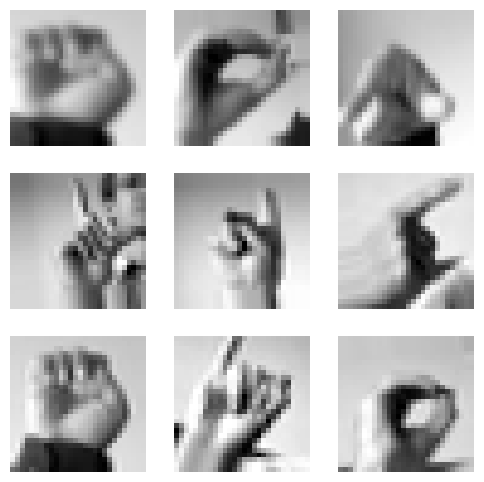

In [4]:
# === Cell 4: Definisikan Augmentasi Citra ===
train_datagen_no_aug = ImageDataGenerator()
train_datagen_aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Simulasi data augmentasi
augmented_example = train_datagen_aug.flow(X_train, y_train, batch_size=9)
images, labels = next(augmented_example)

plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.show()

In [5]:
# === Cell 5: Definisi Arsitektur CNN ===
def build_cnn_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(25, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# === Cell 6: Training Model Tanpa Augmentasi ===
model_no_aug = build_cnn_model()

history_no_aug = model_no_aug.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=64,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - accuracy: 0.3044 - loss: 2.3196 - val_accuracy: 0.8147 - val_loss: 0.6065
Epoch 2/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8299 - loss: 0.5205 - val_accuracy: 0.8887 - val_loss: 0.3387
Epoch 3/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/step - accuracy: 0.9276 - loss: 0.2306 - val_accuracy: 0.8947 - val_loss: 0.2834
Epoch 4/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 27s 63ms/step - accuracy: 0.9591 - loss: 0.1315 - val_accuracy: 0.9099 - val_loss: 0.2973
Epoch 5/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 27s 63ms/step - accuracy: 0.9721 - loss: 0.0883 - val_accuracy: 0.9102 - val_loss: 0.2517
Epoch 6/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - accuracy: 0.9781 - loss: 0.0688 - val_accuracy: 0.9293 - val_loss: 0.2245
Epoch 7/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 27s 63ms/step - accuracy: 0.9810 - loss: 0.0608 - val_accuracy: 0.9172 - val_loss: 0.2450
Epoch 8/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 43s 67ms/step - accuracy: 0.9847 - loss: 0.0489 - 

In [7]:
# === Cell 7: Training Model Dengan Augmentasi ===
model_aug = build_cnn_model()

history_aug = model_aug.fit(
    train_datagen_aug.flow(X_train, y_train, batch_size=64),
    validation_data=(X_test, y_test),
    epochs=15,
    verbose=1
)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


429/429 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.1483 - loss: 2.8594 - val_accuracy: 0.6705 - val_loss: 1.1220
Epoch 2/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 37s 86ms/step - accuracy: 0.4804 - loss: 1.6008 - val_accuracy: 0.8162 - val_loss: 0.6721
Epoch 3/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 35s 82ms/step - accuracy: 0.5910 - loss: 1.1979 - val_accuracy: 0.8408 - val_loss: 0.4799
Epoch 4/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 37s 87ms/step - accuracy: 0.6634 - loss: 0.9978 - val_accuracy: 0.8713 - val_loss: 0.3810
Epoch 5/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - accuracy: 0.7001 - loss: 0.8731 - val_accuracy: 0.9141 - val_loss: 0.3143
Epoch 6/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.7332 - loss: 0.7744 - val_accuracy: 0.9329 - val_loss: 0.2648
Epoch 7/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - accuracy: 0.7548 - loss: 0.7041 - val_accuracy: 0.9201 - val_loss: 0.2282
Epoch 8/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 35s 81ms/step - accuracy: 0.7737 - loss: 0.6533 - val_accurac

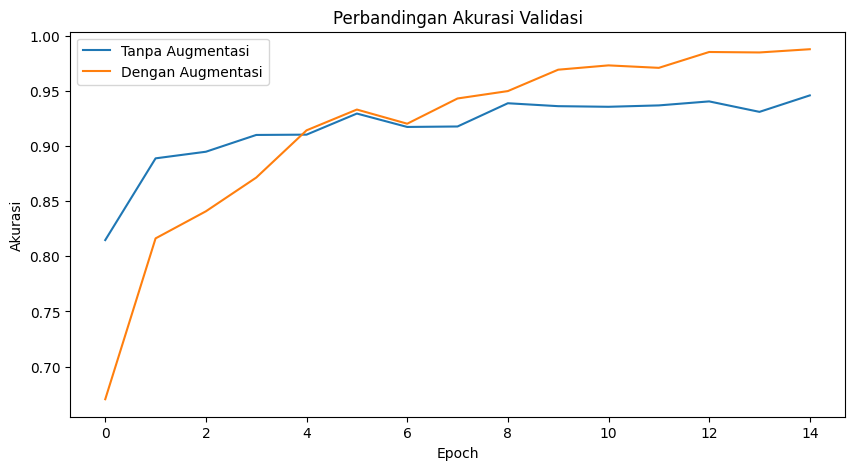

Akurasi tanpa augmentasi: 94.58%
Akurasi dengan augmentasi: 98.76%


In [8]:
# === Cell 8: Evaluasi Model ===
plt.figure(figsize=(10,5))
plt.plot(history_no_aug.history['val_accuracy'], label='Tanpa Augmentasi')
plt.plot(history_aug.history['val_accuracy'], label='Dengan Augmentasi')
plt.title('Perbandingan Akurasi Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

acc_no_aug = model_no_aug.evaluate(X_test, y_test, verbose=0)[1]
acc_aug = model_aug.evaluate(X_test, y_test, verbose=0)[1]
print(f"Akurasi tanpa augmentasi: {acc_no_aug*100:.2f}%")
print(f"Akurasi dengan augmentasi: {acc_aug*100:.2f}%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


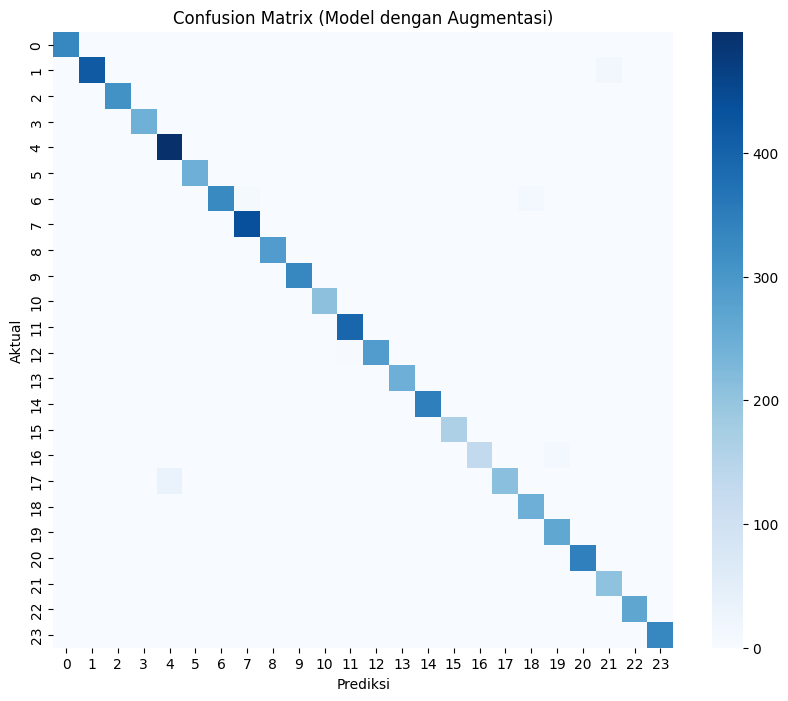

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      0.97      0.98       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       0.93      1.00      0.97       498
           5       1.00      1.00      1.00       247
           6       1.00      0.94      0.97       348
           7       0.98      1.00      0.99       436
           8       1.00      1.00      1.00       288
          10       1.00      1.00      1.00       331
          11       1.00      1.00      1.00       209
          12       0.99      1.00      1.00       394
          13       1.00      0.99      1.00       291
          14       1.00      1.00      1.00       246
          15       1.00      1.00      1.00       347
          16       1.00      1.00      1.00       164
          17       1.00      0.92      0.96       144
          18       1.00    

In [9]:
# === Cell 9: Confusion Matrix & Laporan ===
y_pred_aug = np.argmax(model_aug.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred_aug)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Confusion Matrix (Model dengan Augmentasi)')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

print(classification_report(y_test, y_pred_aug))

In [10]:
# === Cell 10: Simpan Model Terbaik ===
model_aug.save('model_sign_language_best.h5')
print("Model berhasil disimpan ✅")

Model berhasil disimpan ✅


In [11]:
# === Cell 11: Konversi ke TFLite ===
converter = tf.lite.TFLiteConverter.from_keras_model(model_aug)
tflite_model = converter.convert()
open("model_sign_language_best.tflite", "wb").write(tflite_model)
print("Model TFLite berhasil dibuat ✅")

Saved artifact at '/tmp/tmp9a0189pt'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_9')
Output Type:
  TensorSpec(shape=(None, 25), dtype=tf.float32, name=None)
Captures:
  134486873891344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134486873890768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134486873886352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134486873888080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134486873883088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134486873887312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134486873889808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134486873890384: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model TFLite berhasil dibuat ✅


In [12]:
# Simpan label (huruf A-Z, tanpa J dan Z)
labels = [chr(i) for i in range(65, 91) if i not in [74, 90]]
with open("labels.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")